#### Initailization

In [2]:
from feature_extract_func import *

In [1]:
train_design = ["RISCY-a", "RISCY-b", "RISCY-FPU-a", "RISCY-FPU-b"]
test_design_a = ["zero-riscy-a"]
test_design_b = ["zero-riscy-b"]

In [4]:
import models
device = "cuda:4"
opt = {'task': 'congestion_gpdl', 'save_path': 'work_dir/congestion_gpdl/', 'pretrained': '/home/felixchaotw/CircuitNet/model/congestion.pth', 'max_iters': 200000, 'plot_roc': False, 'arg_file': None, 'cpu': False, 'dataroot': '../../training_set/congestion', 'ann_file_train': './files/train_N28.csv', 'ann_file_test': './files/test_N28.csv', 'dataset_type': 'CongestionDataset', 'batch_size': 16, 'aug_pipeline': ['Flip'], 'model_type': 'GPDL', 'in_channels': 3, 'out_channels': 1, 'lr': 0.0002, 'weight_decay': 0, 'loss_type': 'MSELoss', 'eval_metric': ['NRMS', 'SSIM', 'EMD'], 'ann_file': './files/test_N28.csv', 'test_mode': True}
model = models.__dict__["GPDL"](**opt)
model.init_weights(**opt)
model.to(device)

/home/felixchaotw/mllm-physical-design/feat_extract/models/gpdl.py:163: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weight = torch.load(pretrained, map_location='cpu')['st

GPDL(
  (encoder): Encoder(
    (c1): conv(
      (main): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (5): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (c2): conv(
      (main): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.2, inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (

In [3]:
import warnings
warnings.filterwarnings("ignore")

#### Preprocessing

In [5]:
len(feat_func_list)

25

In [6]:
len(feat_pool)

25

In [3]:
import numpy as np
from PIL import Image
import requests, base64
import json
import argparse
from io import BytesIO
import cv2
import heapq

tile_size = 16
image_size = 256


def get_tiles_congestion(image_array):
    tiles = []
    for x in range(0, image_size, tile_size):
        for y in range(0, image_size, tile_size):
            tile = image_array[x:x+tile_size, y:y+tile_size]
            tiles.append(np.mean(tile))
            
    tiles = heapq.nlargest(20, tiles)
    return tiles

file_path = '/data2/NVIDIA/CircuitNet-N28/Dataset/congestion/feature/RISCY-a/165-RISCY-a-1-c2-u0.75-m2-p6-f1.npy'
label_path = '/data2/NVIDIA/CircuitNet-N28/Dataset/congestion/label/RISCY-a/165-RISCY-a-1-c2-u0.75-m2-p6-f1.npy'
numpy_image = np.load(file_path)
label_image = np.load(label_path).squeeze()
batch_image = numpy_image.transpose(2,0,1)
image_features = []
image_inferences = []

for i, image in enumerate(batch_image):
    image_features.append(image)
    image_inferences.append(Image.fromarray(np.uint8(image * 255)))
    
tiles = get_tiles_congestion(label_image)
image_inferences.append(Image.fromarray(np.uint8(label_image * 255)))
print(np.mean(tiles))

0.13181345241170517


In [9]:
base64_images = encode_image(image_inferences)

In [4]:
def get_all_features(images):    
    final_features = {}
    
    for feat_func in feat_func_list:
        feat = feat_func(images)
        final_features.update(feat)
        
    return final_features

In [5]:
from tqdm import tqdm
import os
import torch

def get_gpdl_prediction(design):
     feature_path = f"/data2/NVIDIA/CircuitNet-N28/Dataset/congestion/feature/{design}/" 
     label_path = f"/data2/NVIDIA/CircuitNet-N28/Dataset/congestion/label/{design}/"
     gpdl_prediction = {}
     
     for filename in tqdm(os.listdir(feature_path)):
          file_path = os.path.join(feature_path, filename)
          numpy_image = np.load(file_path)
          batch_image = numpy_image.transpose(2,0,1)
          with torch.no_grad():
               input_image = torch.tensor(batch_image).unsqueeze(0).float().to(device)
               output_image = model(input_image)
               prediction = np.mean(get_tiles_congestion(output_image.cpu().numpy().squeeze()))
          
          gpdl_prediction[filename] = prediction
          
     return gpdl_prediction

gpdl_prediction = {}
gpdl_prediction["RISCY-a"] = get_gpdl_prediction("RISCY-a")
gpdl_prediction["RISCY-b"] = get_gpdl_prediction("RISCY-b")
gpdl_prediction["RISCY-FPU-a"] = get_gpdl_prediction("RISCY-FPU-a")
gpdl_prediction["RISCY-FPU-b"] = get_gpdl_prediction("RISCY-FPU-b")
gpdl_prediction["zero-riscy-a"] = get_gpdl_prediction("zero-riscy-a")
gpdl_prediction["zero-riscy-b"] = get_gpdl_prediction("zero-riscy-b")

  0%|          | 0/2003 [00:00<?, ?it/s]


NameError: name 'device' is not defined

In [ ]:
import re
def total_overcon(logging_file_string):
    matches = re.findall(r"Total overcon =\s*([\d.]+)", logging_file_string)
    if matches:
        ans = float(matches[-1])
    else:
        ans = 0
        
    return ans

#### Fitness Scoring

In [10]:
get_all_features(image_features)

{'rudy_gradient_variability': np.float64(0.4572891352948786),
 'clustered_macro_distance_std': np.float64(0.0),
 'rudy_pin_clustering_coefficient': 0.4359861591695502,
 'macro_density_gradient': np.float64(874.7059464366414),
 'macro_aspect_ratio_variance': np.float64(0.042568930192603056),
 'macro_compactness_index': 6.1548740809059,
 'rudy_pin_compaction_ratio': 0.11856474258970359,
 'macro_variability_coefficient': np.float64(0.34931980631773113),
 'macro_symmetry_coefficient': 0.8191691555796905,
 'macro_cluster_density_contrast': np.float64(-0.5824603185296586),
 'rudy_pin_distribution_kurtosis': np.float64(2.2781733309979826),
 'localized_rudy_variability_coefficient': np.float64(0.2962662431383988),
 'macro_distribution_clarity_index': np.float64(6.133211049089975),
 'rudy_direction_consistency_index': np.float64(0.4621573979588255),
 'rudy_pin_area_masking_index': np.float64(0.12670373592769868),
 'rudy_pin_gradient_convergence': np.float64(0.28121468421904344),
 'rudy_intensit

In [10]:
import pandas as pd
from tqdm.auto import tqdm
import os
import torch
import multiprocessing


def single_extractor(design):
        feature_path = f"/data2/NVIDIA/CircuitNet-N28/Dataset/congestion/feature/{design}/" 
        label_path = f"/data2/NVIDIA/CircuitNet-N28/Dataset/logs/"

        labels = []
        dropped_path = []
        ids = []

        for filename in tqdm(os.listdir(feature_path)):
            file_path = os.path.join(label_path, filename)
            file_path = file_path.replace(".npy", "")
            try:
                with open(file_path, "r") as f:
                    logging_file_string = f.read()
                    
                label = total_overcon(logging_file_string)
            except:
                label = 0
                dropped_path.append(filename)
                
            ids.append(filename)
            labels.append(label)
            
        df = pd.DataFrame({"id": ids,})

        for filename in tqdm(os.listdir(feature_path)):
            file_path = os.path.join(feature_path, filename)
            numpy_image = np.load(file_path)
            batch_image = numpy_image.transpose(2,0,1)
            image_features = []
            for i, image in enumerate(batch_image):
                image_features.append(image)
            
            index = (df["id"] == filename)
            
            all_features = get_all_features(image_features)
            for key, value in all_features.items():
                df.loc[index, key] = value

            # df.loc[index, "prediction_gpdl"] = gpdl_prediction[design][filename]
        
        df['label'] = labels
        for path in dropped_path:
            df.drop(df.index[df['id'] == path], inplace = True)
        df.reset_index(drop=True, inplace=True)
        return df

def dataset_setting(designs):
    pool = multiprocessing.Pool()
    df_list = pool.map(single_extractor, designs)
    return pd.concat(df_list)

In [11]:
train_df = dataset_setting(train_design)
test_df_a = single_extractor(test_design_a[0])
test_df_b = single_extractor(test_design_b[0])

  0%|          | 0/2042 [00:00<?, ?it/s]

  0%|          | 0/2042 [00:00<?, ?it/s]

  0%|          | 0/1122 [00:00<?, ?it/s]

  0%|          | 0/1122 [00:00<?, ?it/s]

In [15]:
train_df.shape, test_df_a.shape, test_df_b.shape

((5597, 27), (1337, 27), (1122, 27))

#### Extend Features

#### Clear Inf

In [15]:
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [16]:
test_df_a.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df_b.replace([np.inf, -np.inf], np.nan, inplace=True)

#### Training

#### Final Selection

In [19]:
# train_df = train_df[list(feat_pool.keys()) + ["id", "label", "prediction_gpdl"]]
# test_df_a = test_df_a[list(feat_pool.keys()) + ["id", "label", "prediction_gpdl"]]
# test_df_b = test_df_b[list(feat_pool.keys()) + ["id", "label", "prediction_gpdl"]]
train_df = train_df[list(feat_pool.keys()) + ["id", "label"]]
test_df_a = test_df_a[list(feat_pool.keys()) + ["id", "label"]]
test_df_b = test_df_b[list(feat_pool.keys()) + ["id", "label"]]

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# Create the parameter grid for GridSearchCV
rf_param_grid = {
    'max_depth': [50, 80, 90, 100], # Maximum number of levels in each decision tree
    'max_features': ["auto", "sqrt", "log2"], # Maximum number of features considered for splitting a node
    'min_samples_leaf': [1, 3, 4, 5], # Minimum number of data points allowed in a leaf node
    'n_estimators': [100, 300, 600, 1000], # Number of trees in the forest
}

# Instantiate the RandomForestRegressor
rf_reg = RandomForestRegressor(random_state=42)

# Setup grid search
rf_grid = GridSearchCV(estimator = rf_reg, param_grid = rf_param_grid, cv=5, verbose=2)

x = train_df.drop(columns=(["id", "label"]))
y = train_df["label"]

In [21]:
rf_grid.fit(x, y)
rf_best = rf_grid.best_estimator_
x_test_a = test_df_a.drop(columns=(["id", "label"]))
x_test_b = test_df_b.drop(columns=(["id", "label"]))
y_pred_test_a = rf_best.predict(x_test_a)
y_pred_test_b = rf_best.predict(x_test_b)
test_df_a["prediction"] = y_pred_test_a
test_df_b["prediction"] = y_pred_test_b

Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, n_estimators=100; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, n_estimators=300; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, n_estimators=300; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, n_estimators=300; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, n_estimators=300; total time=   0.0s
[CV] END max_depth=50, max_features=auto, min_

In [22]:
rf_grid.best_params_

{'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'n_estimators': 300}

In [25]:
x = train_df.drop(columns=(["id", "label",]))
y = train_df["label"]
x_test_a = test_df_a.drop(columns=(["id", "label","prediction"]))
x_test_b = test_df_b.drop(columns=(["id", "label","prediction"]))


In [17]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(random_state=42, max_depth=50, max_features='sqrt', min_samples_leaf=1, n_estimators=300)
rf_reg.fit(x, y)
y_pred_test_a = rf_reg.predict(x_test_a)
y_pred_test_b = rf_reg.predict(x_test_b)
test_df_a["prediction"] = y_pred_test_a
test_df_b["prediction"] = y_pred_test_b

In [18]:
test_df_a = test_df_a.drop_duplicates(subset=["label"])
test_df_b = test_df_b.drop_duplicates(subset=["label"])

In [25]:
from scipy import stats
from sklearn.metrics import ndcg_score
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
plt.style.use(['science','grid','retro'])

def replaceWithRank(arr):
    n = len(arr)
    res = [0] * n
    pq = []
    for i in range(n):
        heapq.heappush(pq, (arr[i], i))

    rank = 0
    lastNum = float('inf')

    while pq:
        curr, index = heapq.heappop(pq)

        if lastNum == float('inf') or curr != lastNum:
            rank += 1
            
        res[index] = rank - 1
        lastNum = curr

    return res

def evalute_corr(congestion_set, predicted, corr_metrics):
    x = np.array(list(congestion_set.values()))
    x_label = list(congestion_set.keys())
    y = np.array([predicted[id] for id in x_label])
    results = {}
    if "PLCC" in corr_metrics:
        results["PLCC"] = stats.pearsonr(x, y)
    if "SRCC" in corr_metrics:
        results["SRCC"] = stats.spearmanr(x, y)
    if "KRCC" in corr_metrics:
        results["KRCC"] = stats.kendalltau(x, y)
    
    return results


def evaluate_design(df):
    congestion_set = dict(zip(df["id"], df["label"]))
    congestion_set = dict(sorted(congestion_set.items(), key=lambda x: x[1]))
    predicted = dict(zip(df["id"], df["prediction"]))
    corr_metrics = ["PLCC", "SRCC", "KRCC"]
    results = evalute_corr(congestion_set, predicted, corr_metrics)
    x = list(congestion_set.keys())[::20]
    x = [name.split("-")[0] for name in x]
    x_label = list(range(0,len(x)))
    y = [predicted[file_path] for file_path in congestion_set.keys()][::20]
    y_label = replaceWithRank(y)
    plt.figure(figsize=(10,5))
    plt.plot(x, y_label, linewidth="2", marker="o")
    plt.plot(x, x_label, linewidth="2", marker="o")
    plt.xticks(ticks=x_label, labels=x, rotation=90)
    plt.xlabel("Images")
    plt.ylabel("Rank Order")
    plt.title("GPDL + GARF")
    return results

#### Without GPDL

{'PLCC': PearsonRResult(statistic=np.float64(0.7050186455297291), pvalue=np.float64(5.639189884207843e-84)),
 'SRCC': SignificanceResult(statistic=np.float64(0.7860487900320193), pvalue=np.float64(8.956420138493225e-117)),
 'KRCC': SignificanceResult(statistic=np.float64(0.5954559711619437), pvalue=np.float64(5.509797510860791e-97))}

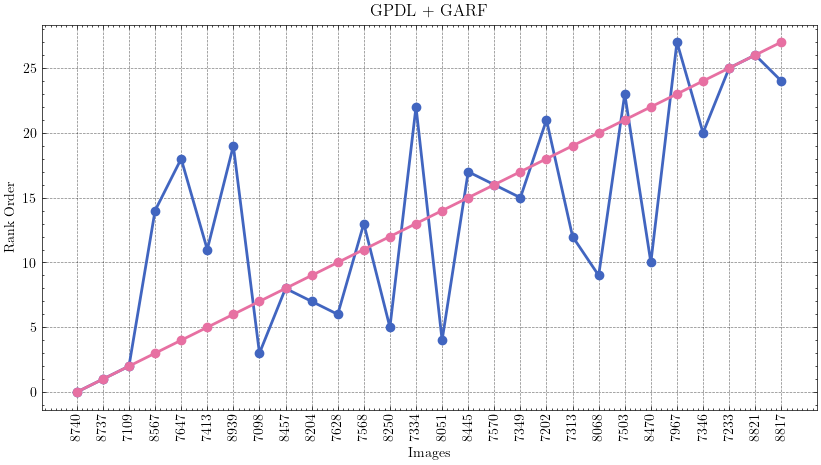

In [30]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.5992960199316076), pvalue=np.float64(3.022527322704861e-44)),
 'SRCC': SignificanceResult(statistic=np.float64(0.5906493329965951), pvalue=np.float64(1.0035090318903202e-42)),
 'KRCC': SignificanceResult(statistic=np.float64(0.4116629821499716), pvalue=np.float64(4.6966606300854004e-38))}

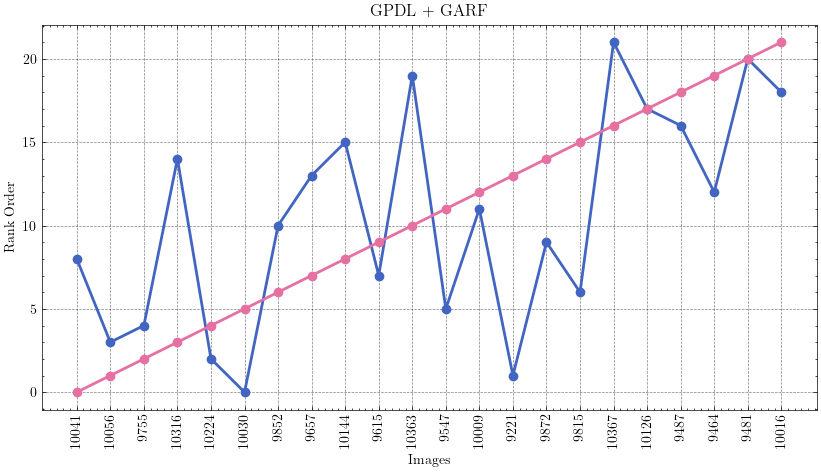

In [31]:
evaluate_design(test_df_b)

Text(0, 0.5, 'Feature')

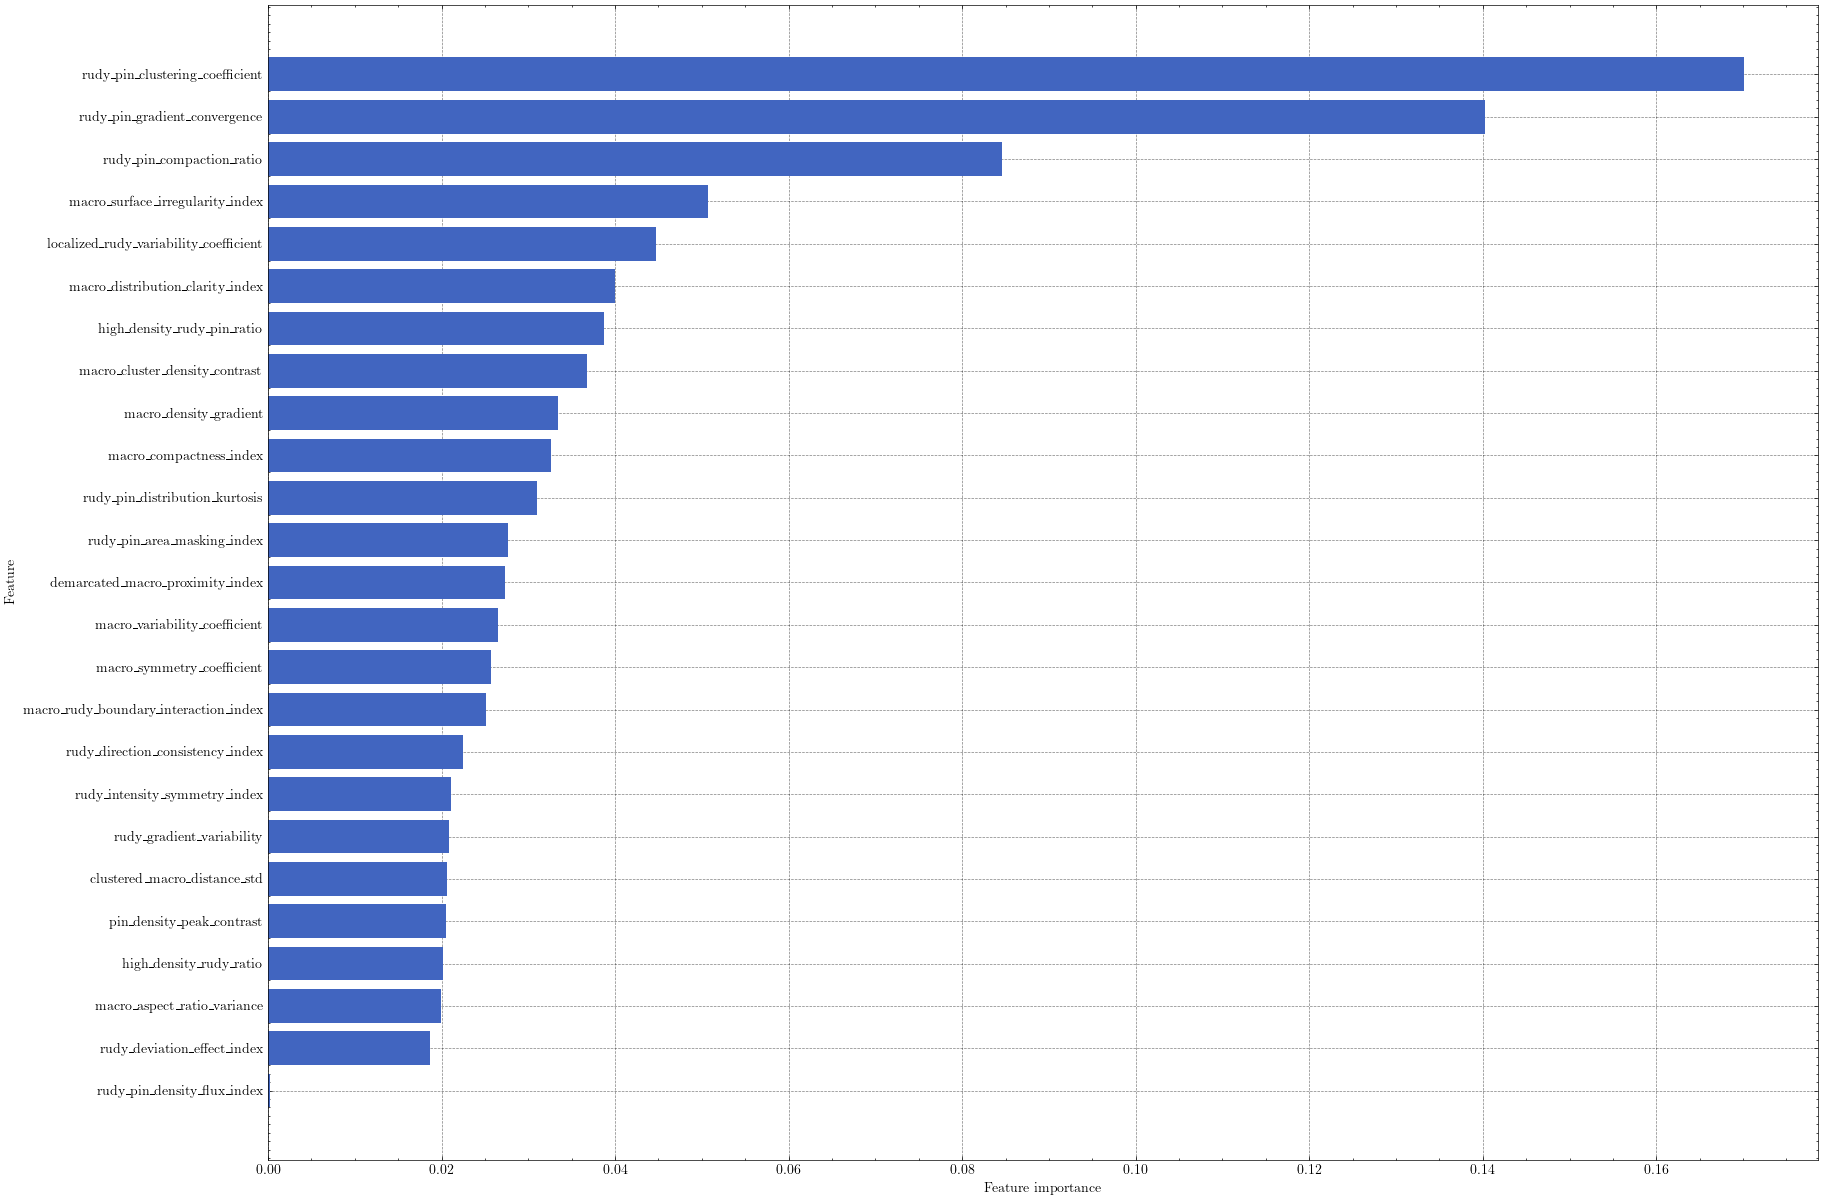

In [32]:
feature_importance = rf_reg.feature_importances_ 
sorted_idx = np.argsort(feature_importance) # Sort index on feature importance
fig = plt.figure(figsize=(20, 15)) # Set plot size (denoted in inches)
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x.columns)[sorted_idx])

plt.xlabel("Feature importance") # Add x axis
plt.ylabel("Feature") # Add y axis

### Cross-over Only

In [9]:
from feature_extract_cross_over import *

In [10]:
len(feat_func_list), len(feat_pool)

(19, 19)

In [11]:
get_all_features(image_features)

{'macro_spacing_std': 0.0,
 'macro_boundary_distance_var': np.float64(18066.0849609375),
 'pin_clustering_factor': np.float64(2.0314252912791952e-05),
 'macro_diagonal_connectivity': np.float64(116113.5),
 'rudy_gradation_smoothness': np.float64(0.20607714130778726),
 'macro_edge_proximity_to_pins': 18.0,
 'macro_cluster_compactness': 2.479558417526037,
 'pin_density_variance': np.float64(1.3237166183145824e-05),
 'pin_neighborhood_uniformity': np.float64(-24.226834927372348),
 'rudy_consistency_index': np.float64(1.0187817818468574),
 'pin_to_macro_rudy_gradient_proximity': np.float64(712.7892343545373),
 'sector_rudy_disparity': np.float64(0.2726566797402793),
 'macro_corner_count': 8,
 'pin_to_macro_edge_proximity_std': np.float32(53.208954),
 'macro_linear_alignment': 0.0,
 'rudy_peak_clustering': np.float64(168.926176071167),
 'macro_pin_alignment_score': 10.125,
 'pin_density_gradient': np.float64(28633.644990650868),
 'macro_to_pin_cluster_proximity': np.float64(310.665286737192

In [17]:
train_df.shape, test_df_a.shape, test_df_b.shape

((5597, 21), (1337, 21), (1122, 21))

In [18]:
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df_a.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df_b.replace([np.inf, -np.inf], np.nan, inplace=True)

In [19]:
train_df = train_df[feat_pool + ["id", "label"]]
test_df_a = test_df_a[feat_pool + ["id", "label"]]
test_df_b = test_df_b[feat_pool + ["id", "label"]]

In [22]:
x = train_df.drop(columns=(["id", "label",]))
y = train_df["label"]
x_test_a = test_df_a.drop(columns=(["id", "label",]))
x_test_b = test_df_b.drop(columns=(["id", "label",]))

{'PLCC': PearsonRResult(statistic=np.float64(0.6298371601683825), pvalue=np.float64(3.082854600337943e-62)),
 'SRCC': SignificanceResult(statistic=np.float64(0.6736430009513134), pvalue=np.float64(4.043318316581951e-74)),
 'KRCC': SignificanceResult(statistic=np.float64(0.4920223742559786), pvalue=np.float64(8.130996445524094e-67))}

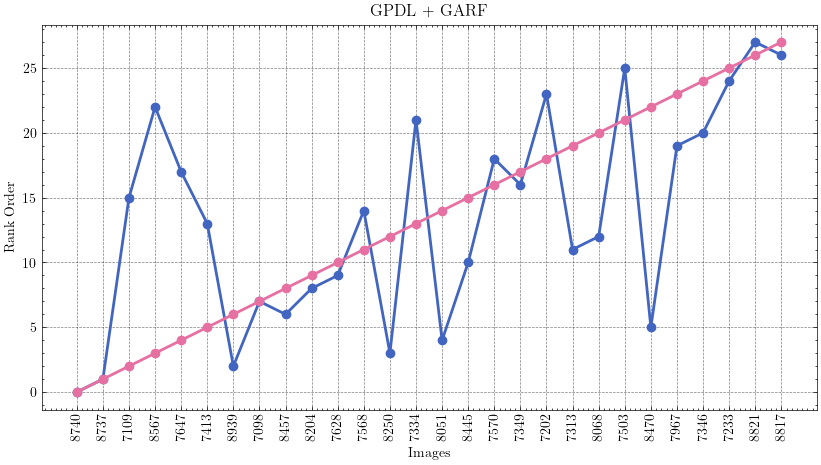

In [29]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.5890283537008091), pvalue=np.float64(1.9125307702057952e-42)),
 'SRCC': SignificanceResult(statistic=np.float64(0.6860533460001755), pvalue=np.float64(1.7367784333071867e-62)),
 'KRCC': SignificanceResult(statistic=np.float64(0.49344868331382474), pvalue=np.float64(6.567984907620186e-54))}

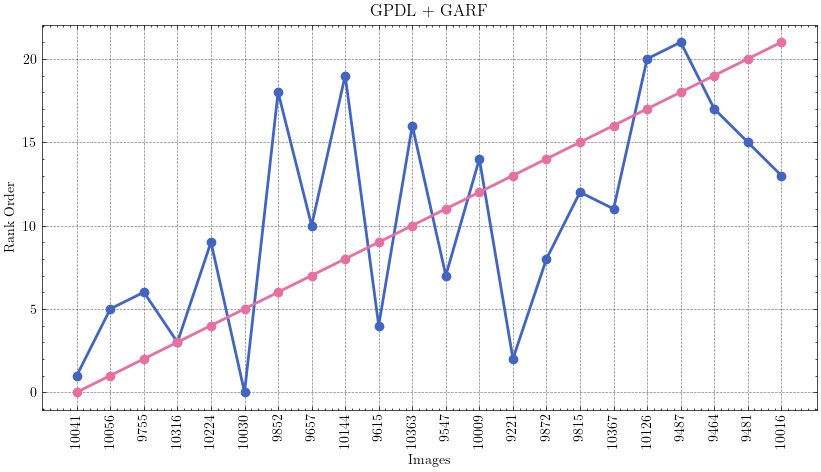

In [30]:
evaluate_design(test_df_b)

### Mutation Only

In [7]:
from feature_extract_mutation import *

In [8]:
len(feat_func_list), len(feat_pool)

(20, 20)

In [9]:
get_all_features(image_features)

{'average_macro_angular_centrality': np.float64(9.409739241253252),
 'high_density_rudy_pin_ratio': np.float64(0.3642730712890625),
 'mean_macro_neighborhood_density': np.float64(233.84743163262226),
 'macro_congestion_potential_index': np.float64(0.014364517669234123),
 'mean_rudy_gradient_magnitude': np.float64(0.46367356794252135),
 'max_macro_contact_density': 1.1301326751708984,
 'mean_rudy_pin_centrality': np.float64(198.3740292159854),
 'macro_gradient_variation_index': np.float64(253.6478484549838),
 'mean_rudy_pin': np.float64(0.12570773813591224),
 'mean_macro_central_congestion_intensity': np.float64(0.04968365793567009),
 'mean_macro_curvature_variance': np.float64(1.8537089921619015e-05),
 'high_density_rudy_ratio': np.float64(0.4040985107421875),
 'mean_macro_radial_convergence': np.float64(5.65585675441876),
 'PAR_rudy_pin': np.float64(7.954959772793172),
 'macro_neighbor_proximity_variance': np.float64(0.0),
 'mean_macro_core_to_rudy_edge_distance': np.float32(111.06353

In [12]:
train_df.shape, test_df_a.shape, test_df_b.shape

((5597, 22), (1337, 22), (1122, 22))

In [13]:
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df_a.replace([np.inf, -np.inf], np.nan, inplace=True)
test_df_b.replace([np.inf, -np.inf], np.nan, inplace=True)

In [15]:
train_df = train_df[list(feat_pool.keys()) + ["id", "label"]]
test_df_a = test_df_a[list(feat_pool.keys()) + ["id", "label"]]
test_df_b = test_df_b[list(feat_pool.keys()) + ["id", "label"]]

In [16]:
x = train_df.drop(columns=(["id", "label",]))
y = train_df["label"]
x_test_a = test_df_a.drop(columns=(["id", "label",]))
x_test_b = test_df_b.drop(columns=(["id", "label",]))

{'PLCC': PearsonRResult(statistic=np.float64(0.3534059422566271), pvalue=np.float64(1.1850489404269589e-17)),
 'SRCC': SignificanceResult(statistic=np.float64(0.4847838151215936), pvalue=np.float64(8.064015432105624e-34)),
 'KRCC': SignificanceResult(statistic=np.float64(0.3478014095042463), pvalue=np.float64(2.8613433911733343e-34))}

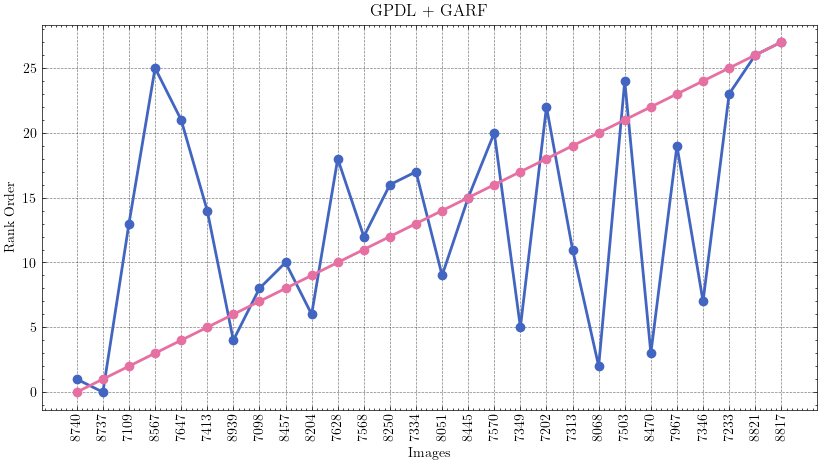

In [21]:
evaluate_design(test_df_a)

{'PLCC': PearsonRResult(statistic=np.float64(0.46853885800785733), pvalue=np.float64(2.152495610285216e-25)),
 'SRCC': SignificanceResult(statistic=np.float64(0.4623790322383762), pvalue=np.float64(1.0834692766934618e-24)),
 'KRCC': SignificanceResult(statistic=np.float64(0.313574001650771), pvalue=np.float64(8.896691285047744e-23))}

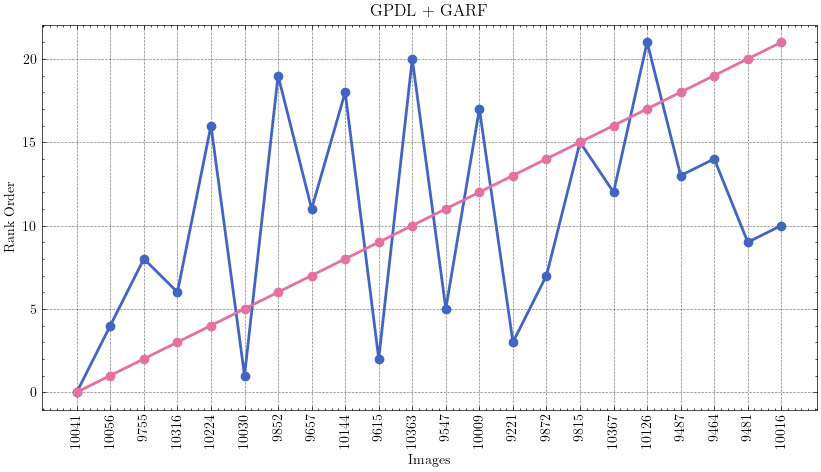

In [26]:
evaluate_design(test_df_b)